In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import healpy as hp
import tqdm


sys.path.append('../pipeline_scripts/')
from pipeline_main import serialize_dictionary, pipeline
from plotting_setup import *


In [3]:
data = pipeline(snap = 223, run = 'sink13fmr05', sink_id=13)

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:13<00:00, 315.52it/s]


In [4]:
map_data = serialize_dictionary(filename = 'sink13fmr05_accretion_maps.pkl', store = False)

In [5]:
nside = 45
npix = hp.nside2npix(nside)
shell_r = 50 / data.au_length
Lat = np.unique(hp.pix2ang(nside, np.arange(npix))[0]) - np.pi/2

time = map_data['time']
t_new = time[time != 0].copy()

In [11]:
hp.pix2ang(48, 0),

((0.017010550524960123, 0.7853981633974483), 1.5707963267948966)

In [8]:
hp.pix2ang(nside, np.arange(npix))

(array([0.01814462, 0.01814462, 0.01814462, ..., 3.12344804, 3.12344804,
        3.12344804]),
 array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
        5.49778714]))

In [27]:
infall = np.zeros((len(t_new), len(Lat) - 1))
pct = np.array([25, 50, 75, 100])
area_data = np.zeros((len(pct), len(t_new)))
pct_in = np.zeros_like(t_new)
cum_lat = np.zeros_like(area_data)
sec_lat = np.zeros_like(area_data)
out_lat = np.zeros_like(t_new)
acc = np.zeros_like(t_new)
out = np.zeros_like(t_new)

for t in tqdm.tqdm(range(len(t_new))):
    map = map_data['maps'][time != 0][t]
    bool_pos = map > 0; bool_neg = map < 0
    inflow_pixels = map[bool_pos]
    outflow_pixels = map[bool_neg]

    acc[t] = np.sum(inflow_pixels); out[t] = np.sum(outflow_pixels)

    Lat_in, _ = hp.pix2ang(nside, np.arange(npix)[bool_pos]) 
    Lat_out, _ = hp.pix2ang(nside, np.arange(npix)[bool_neg]) 
    infall_index = np.argsort(inflow_pixels)[::-1]

    pct_in[t] = len(Lat_in) / npix * 100

    cell_area = hp.nside2pixarea(nside) * shell_r**2

    sphere_area = cell_area * npix 

    x = np.arange(len(inflow_pixels)) * cell_area / sphere_area * 100
    y = np.cumsum(inflow_pixels[infall_index]) / np.sum(inflow_pixels) * 100

    if len(y) == 0: continue

    indicies = [np.argmin(abs(y - p)) for p in pct]    
    area_data[:,t] = x[indicies]

    cum_lat[:,t] = [np.average(Lat_in[infall_index][:j], weights=inflow_pixels[infall_index][:j]) for j in indicies]
    out_lat[t] = np.average(Lat_out)#, weights=outflow_pixels)

    k0 = 0
    for i, k in enumerate(indicies):
        sec_lat[i,t] = np.average(Lat_in[infall_index][k0:k], weights=inflow_pixels[infall_index][k0:k])
        k0 = k.copy()


100%|██████████| 274/274 [00:03<00:00, 88.95it/s]


In [56]:
shell_r

6.0596241088788074e-05

In [6]:
flux = {
    'Inflow': pct_in,
    'Outflow': 100 - pct_in}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


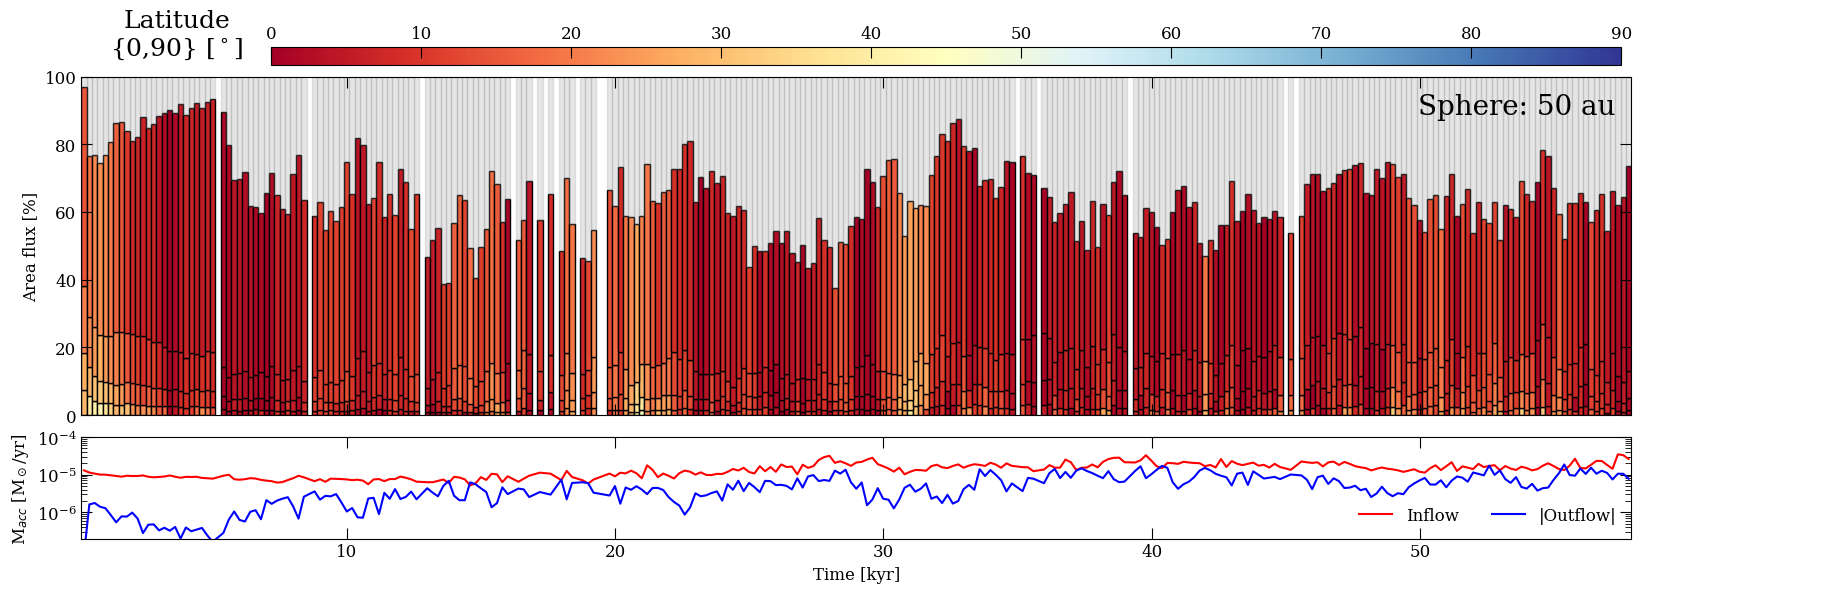

In [55]:
show_outflow_deg = False
bins = np.unique(hp.pix2ang(nside, np.arange(npix))[0])


fig, ax = plt.subplots(2, 1, figsize = (20,6), gridspec_kw={'height_ratios': [5,1.5]}, sharex = True)


axs = ax[1]

axs.semilogy(t_new*1e-3, acc, color = 'red', label = 'Inflow')
axs.semilogy(t_new*1e-3, abs(out), color = 'blue', label = '|Outflow|')

axs.set(ylabel = 'M$_{acc}$ [M$_\odot$/yr]', xlabel = 'Time [kyr]', ylim = (2e-7, 1e-4))
axs.legend(frameon = False, ncol = 2)



axs = ax[0]
deg_bins = np.linspace(0, 90, 100)
lat_colors = plt.cm.RdYlBu(np.linspace(0,1, 100))

bottom = np.zeros_like(t_new)
to_bar = np.vstack((area_data[0,:], np.diff(area_data, axis = 0)))


for i, p in enumerate(pct):
    deg = np.rad2deg(abs(cum_lat[i] - np.pi/2))
    bar_color = np.array([np.argmin(abs(deg[t] - deg_bins)) for t in range(len(t_new))]).copy()
    axs.bar(t_new*1e-3, to_bar[i,:], width = 0.2, align='center', label = p, bottom=bottom, fill=True, edgecolor = 'black', color = lat_colors[bar_color])
    bottom += to_bar[i,:]


if show_outflow_deg: 
    deg_out = np.rad2deg(abs(out_lat - np.pi/2))
    out_color = np.array([np.argmin(abs(deg_out[t] - deg_bins)) for t in range(len(t_new))]).copy()
    axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:], label = 'Outflow', color = lat_colors[out_color], alpha = 0.5)
else:
    axs.bar(t_new*1e-3, flux['Outflow'], width =0.2, align='center', bottom=area_data[-1,:], label = 'Outflow', color = 'grey', alpha = 0.2, edgecolor = 'grey')

axs.set(xlim = (t_new[0]*1e-3-0.1,t_new[-1]*1e-3+0.1), ylim = (0,100), ylabel = 'Area flux [%]')

cbaxes = fig.add_axes([0.22, 0.9, 0.675, 0.03])
norm = plt.Normalize(vmin=min(deg_bins), vmax=max(deg_bins)) 
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, norm=norm); sm.set_array([])

cbar = fig.colorbar(sm, cax=cbaxes, orientation='horizontal')  # Create the colorbar
cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('Latitude\n{0,90} [$^\circ$]', labelpad = -40, x = -0.07, rotation = 0, fontsize = 18)

axs.text(0.99, 0.95, 'Sphere: 50 au', transform=axs.transAxes, ha='right', va='top', fontsize = 20)

plt.legend(loc = 'upper right', bbox_to_anchor = (1.15,1), frameon = False)

fig.subplots_adjust(wspace=0, hspace=0.1)